# import

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import logging
from dataset import pil_loader
from model.ANFL import MEFARG
from utils import *
from conf import get_config,set_logger,set_outdir,set_env
import cv2
from PIL import Image
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [2]:
AU_name_lists = ['Inner brow raiser',
        'Outer brow raiser',
        'Brow lowerer',
        'Upper lid raiser',
        'Cheek raiser',
        'Lid tightener',
        'Nose wrinkler',
        'Upper lip raiser',
        'Nasolabial deepener',
        'Lip corner puller',
        'Sharp lip puller',
        'Dimpler',
        'Lip corner depressor',
        'Lower lip depressor',
        'Chin raiser',
        'Lip pucker',
        'Tongue show',
        'Lip stretcher',
        'Lip funneler',
        'Lip tightener',
        'Lip pressor',
        'Lips part',
        'Jaw drop',
        'Mouth stretch',
        'Lip bite',
        'Nostril dilator',
        'Nostril compressor',
        'Left Inner brow raiser',
        'Right Inner brow raiser',
        'Left Outer brow raiser',
        'Right Outer brow raiser',
        'Left Brow lowerer',
        'Right Brow lowerer',
        'Left Cheek raiser',
        'Right Cheek raiser',
        'Left Upper lip raiser',
        'Right Upper lip raiser',
        'Left Nasolabial deepener',
        'Right Nasolabial deepener',
        'Left Dimpler',
        'Right Dimpler']

AU_name_lists1 =  ['AU1:','AU2:','AU4:','AU5:','AU6:','AU7:','AU9:','AU10:','AU11:',
      'AU12:','AU13:','AU14:','AU15:','AU16:','AU17:','AU18:','AU19:','AU20:',
      'AU22:','AU23:','AU24:','AU25:','AU26:','AU27:','AU32:','AU38:','AU39:',
      'AUL1:','AUR1:','AUL2:','AUR2:','AUL4:','AUR4:','AUL6:','AUR6:','AUL10:',
      'AUR10:','AUL12:','AUR12:','AUL14:','AUR14:']

# prepare net and weights

In [3]:
def make_net():
    path = "./checkpoints/OpenGprahAU-ResNet50_first_stage.pth"
    net = MEFARG(num_main_classes=27, num_sub_classes=14, backbone="resnet", neighbor_num=4)
    net = load_state_dict(net, path)
    return net

# face align

In [4]:
def ang(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = ang(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M


def cal(M,P,B,scale=1):
    eye_cent = (P[0,:]+P[1,:])/2
    nose_cent = (eye_cent+P[3,:])/2
    cent = M@np.append(nose_cent,[1])
    half = int(np.linalg.norm(eye_cent-P[3,:])*3/2*scale)
    half = (half,half)
    return cent.astype(np.int32), half

def crop_image(image,M,P,B):
    h, w = image.shape[:2]
    cent, half = cal(M,P,B)
    cx,cy = cent
    half_h,half_w = half
    
    x0 = cx-half_w if cx-half_w>=0 else 0
    x1 = cx+half_w if cx+half_w<=w else w
    y0 = cy-half_h if cy-half_h>=0 else 0
    y1 = cy+half_h if cy+half_h<=h else h
    return image[y0:y1,x0:x1,:]

In [5]:
def face_align(image):
    height, width = image.shape[:2]
    with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
        image.flags.writeable = False
        results = face_detection.process(image)
    
        if results.detections:
            points = results.detections[0].location_data.relative_keypoints
            P = []
            for i in range(6):
                P.append((points[i].x*width,points[i].y*height))
            P = np.array(P)
            bbox = results.detections[0].location_data.relative_bounding_box
            B = []
            B.append(bbox.xmin*width)
            B.append(bbox.ymin*height)
            B.append(bbox.width*width)
            B.append(bbox.height*height)
            B = np.array(B)

            M = get_rotation_matrix(P[0], P[1])
            res = cv2.warpAffine(image, M, (width,height), flags=cv2.INTER_CUBIC)

            res = crop_image(res,M,P,B)
            return res
        else:
            return image


# pretty draw AU inference results

In [6]:
def pretty_draw(image,pred):
    image = cv2.resize(np.array(image),(480,480))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR )
    dataset_info = hybrid_prediction_infolist
    infostr_probs,  infostr_aus = dataset_info(pred, 0.5)
    blank = np.ones((480, 640, 3),np.uint8)*255
    for i in range(21):
        text = AU_name_lists[i]+AU_name_lists1[i]
        if pred[i]>0.5:
            color = (255,0,0)
        else:
            color = (255,255,0)
        posi = (0,20*i+20)
        cv2.putText(blank,text,posi,cv2.FONT_HERSHEY_COMPLEX,0.4,color,1)
    for i in range(22,41):
        text = AU_name_lists[i]+AU_name_lists1[i]
        if pred[i]>0.5:
            color = (255,0,0)
        else:
            color = (255,255,0)
        posi = (320,20*(i-22)+20)
        cv2.putText(blank,text,posi,cv2.FONT_HERSHEY_COMPLEX,0.4,color,1)   
    return np.hstack((image,blank))

In [7]:
pred = 0
def pipeline(image):
    img_transform = image_eval()
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
    img = face_align(img)
    img = Image.fromarray(img)
#     img = pil_loader('./demo_imgs/1014.jpg').rotate(0)
    
    img_ = img_transform(img).unsqueeze(0)
    net.eval()
    with torch.no_grad():
        global pred
        pred = net(img_)
        pred = pred.squeeze().cpu().numpy()
        image = pretty_draw(img,pred)
    return image

# close camera

In [8]:
try:
    cap.release()
    cv2.destroyAllWindows()
except:
    pass

# cap

In [13]:
net = make_net()
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
# cap.set(3, 1280)  # width=1920
# cap.set(4, 960)
while True:
    success, image = cap.read()
    image = pipeline(image)
    cv2.imshow('AU detector', image)
    if cv2.waitKey(1) & 0xFF == ord('q'): # 一帧显示一毫秒，通过上面的while循环不断地显示下一帧，从而形成动态的视频；按q键退出循环，关闭视频。
        break
cap.release()
cv2.destroyAllWindows()

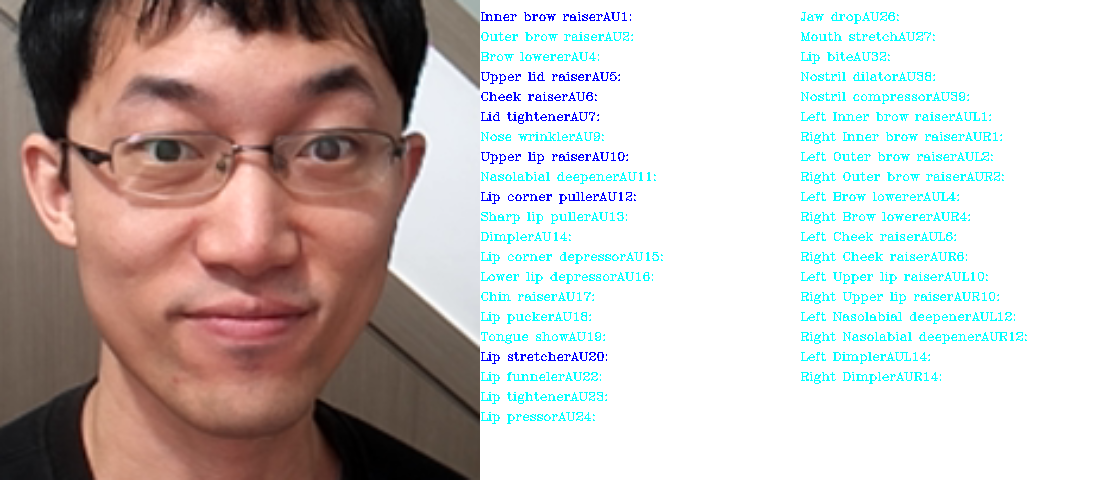

In [12]:
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB ))

# mediapipe facedec

In [171]:
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
# cap.set(3, 1280)  # width=1920
# cap.set(4, 960)

with mp_face_detection.FaceDetection(
    model_selection=0, min_detection_confidence=0.5) as face_detection:
    while True:
        success, image = cap.read()
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.detections:
            for detection in results.detections:
                mp_drawing.draw_detection(image, detection)
        # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Face Detection', cv2.flip(image, 1))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

144.0 310.0


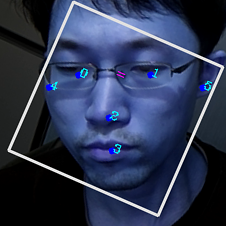

In [251]:
height, width = image.shape[:2]

points = results.detections[0].location_data.relative_keypoints
P = []
for i in range(6):
    P.append((points[i].x*width,points[i].y*height))
P = np.array(P)
bbox = results.detections[0].location_data.relative_bounding_box
B = []
B.append(bbox.xmin*width)
B.append(bbox.ymin*height)
B.append(bbox.width*width)
B.append(bbox.height*height)
B = np.array(B)

M = get_rotation_matrix(P[0], P[1])
res = cv2.warpAffine(image, M, (width,height), flags=cv2.INTER_CUBIC)

res = crop_image(res)
Image.fromarray(res)